Denoise Autoencoder with Fashion MNIST
===

- Train Autoencoder to denoise input images and reconstruct clear images.
- Speed up by binary_crossentropy in calculating reconstruction loss.

# Setup

In [1]:
import sklearn
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
# @title utility function to render image
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# Load training data


In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
X_train.shape

4422102/4422102 [==============================] - 0s 0us/step


(55000, 28, 28)

# Autoencoder

- To make the learning speed faster, binary crossentropy can be used to calculate the loss by rounding the pixcel values to 0 or 1.
- This is possible because the trainign data is gray scaled.

In [4]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(
        tf.round(y_true), # round to 0 or 1 to use binary_crossentropy
        tf.round(y_pred))

In [6]:
LATENT_DIM = 30
IMAGE_SIZE = 28
HIDDEN_DIM = 100
LEARNING_RATE = 0.5

encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(IMAGE_SIZE, IMAGE_SIZE)),
    keras.layers.GaussianNoise(0.2), # intentionally apply noise. Another option is keras.layers.Dropout(0.1).
    keras.layers.Dense(HIDDEN_DIM, activation='selu'),
    keras.layers.Dense(LATENT_DIM, activation='selu'),
])
decoder = keras.models.Sequential([
    keras.layers.Dense(HIDDEN_DIM, input_shape=(LATENT_DIM,)),
    keras.layers.Dense(IMAGE_SIZE * IMAGE_SIZE, activation='sigmoid'),
    keras.layers.Reshape((IMAGE_SIZE, IMAGE_SIZE))
])
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(
    # 多ラベル２項分類問題として扱い、個々のピクセルの明度はピクセルを黒にすべき確率を表す
    # 回帰問題とするよりも収束が早くなる
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE),

    # 正解率は個々のピクセルのラベルが0か1であることを前提としているのでカスタム指標が必要
    # 正解と予測を0か1に丸めてから正解率を計算する必要がある
    metrics=[rounded_accuracy]
)
print(autoencoder.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 30)                81530     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            82284     
                                                                 
Total params: 163814 (639.90 KB)
Trainable params: 163814 (639.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# Train

In [7]:
history = autoencoder.fit(X_train, X_train, epochs=20,
                          validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3678 - rounded_accuracy: 0.8614 - val_loss: 0.3238 - val_rounded_accuracy: 0.9013
Epoch 2/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3189 - rounded_accuracy: 0.9042 - val_loss: 0.3149 - val_rounded_accuracy: 0.9082
Epoch 3/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3117 - rounded_accuracy: 0.9106 - val_loss: 0.3089 - val_rounded_accuracy: 0.9152
Epoch 4/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3075 - rounded_accuracy: 0.9143 - val_loss: 0.3057 - val_rounded_accuracy: 0.9189
Epoch 5/20
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3047 - rounded_accuracy: 0.9167 - val_loss: 0.3030 - val_rounded_accuracy: 0.9207
Epoch 6/20
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3025 - rounded_accuracy: 0.9185 - val_loss: 0.3009 - val_rounded_accuracy: 0.9219
Epoch 7/20
1719/1719 [===========

Retrieve some image samples and pass through autoencoder
and compare the inputs with the reconstructed ones.

In [8]:
def show_reconstructions(model, images=X_valid, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 105ms/step


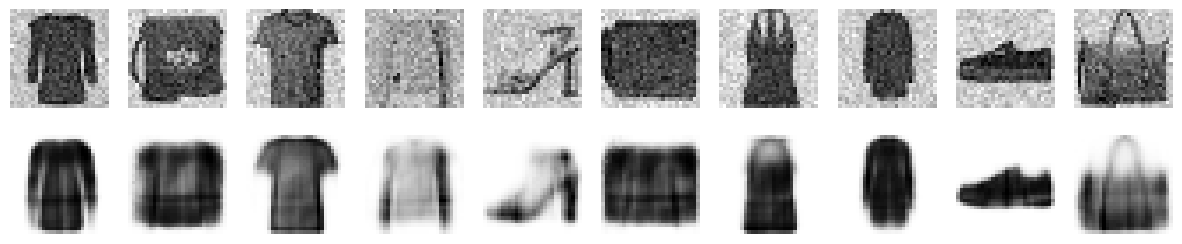

In [9]:
noise = keras.layers.GaussianNoise(0.1)
show_reconstructions(autoencoder, noise(X_valid, training=True))

1/1 [==============================] - 0s 74ms/step


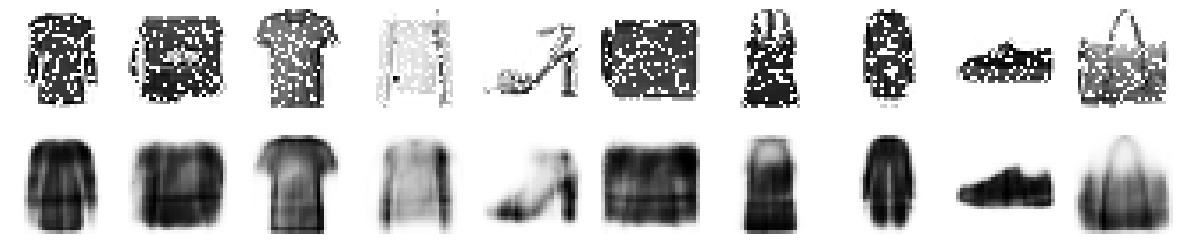

In [12]:
noise = keras.layers.Dropout(0.2)
show_reconstructions(autoencoder, noise(X_valid, training=True))